<a href="https://colab.research.google.com/github/PaulaBergamasco/BCI/blob/main/Mentoria_TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyforest

  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14607 sha256=e071fb40c728231baf7e6f44a7940328a86f8015d1c2eebcac7a55b7d20d722a
  Stored in directory: /root/.cache/pip/wheels/61/1c/da/48e6c884142d485475d852d69d20a096aba5beceb338822893
Successfully built pyforest


In [ ]:
from pathlib import Path
import numpy as np
import pyforest
from typing import Callable
import scipy
import scipy.signal as sgn
import matplotlib.pyplot as plt

In [ ]:
#utils
import itertools
import numpy as np
import pandas as pd
from csv import reader
from pathlib import Path
from scipy import signal


def has_metadata(csv_path):
    f = open(csv_path, newline='')
    csv_reader = reader(f)
    return True if next(csv_reader)[0] == '%OpenBCI Raw EEG Data' else False


def raw_read_bci_csv(csv_path):
    csv_reader = reader(open(csv_path, newline=''))
    n_lines = 10 if next(csv_reader)[0] == '%OpenBCI Raw EEG Data' else 0
    column_names = [
        'sample_index', 'ch0', 'ch1', 'ch2', 'ch3', 'acc0',
        'acc1', 'acc2', 'label', 'provided_time', 'timestamp'
    ]
    dataset = pd.read_csv(csv_path, skiprows=n_lines, index_col=False, names=column_names)
    sample_rate = 200.
    dataset['time'] = dataset.index.values/sample_rate
    return dataset


def clean_read_bci_csv(csv_path):
    dataset = raw_read_bci_csv(csv_path)
    dataset.drop(columns=['sample_index', 'acc0', 'acc1', 'acc2', 'provided_time', 'timestamp'], inplace=True)
    return dataset


def add_sub_label(dataset):
    labels = dataset.label.unique().tolist()
    for label in labels:
        sample_idx = dataset.loc[dataset.label == label].index.values
        gap_btn_idx = sample_idx[1:] - sample_idx[:-1]
        selected_idx = np.insert((gap_btn_idx != 1), 0, True)
        desired_idx_bottom = sample_idx[selected_idx]
        selected_idx = np.append(selected_idx[1:], True)
        desired_idx_top = sample_idx[selected_idx]
        for k, (start, stop) in enumerate(zip(desired_idx_bottom, desired_idx_top)):
            selection = (dataset.index.values >= start) & (dataset.index.values <= stop)
            dataset.loc[selection, 'sub_label'] = f'{label}-{k}'
    return dataset


def detrend_channels(dataset, mode='both', window=200):
    if mode in ['global', 'both']:
        detrend_global = dataset.copy()
    if mode in ['both', 'local']:
        detrend_local = dataset.copy()
    for subject in dataset.subject.unique():
        selection = (dataset.subject == subject)
        for session in dataset.loc[selection, 'session'].unique():
            selection2 = selection & (dataset.session == session)
            if mode in ['global', 'both']:
                for ch in ['ch0', 'ch1', 'ch2', 'ch3']:
                    y = dataset.loc[selection2, ch].values
                    detrend_global.loc[selection2, ch] = signal.detrend(y)
            if mode in ['both', 'local']:
                for ch in ['ch0', 'ch1', 'ch2', 'ch3']:
                    index = dataset.loc[selection2].index.tolist()
                    iters = [iter(index)] * window
                    for k, index_set in enumerate(itertools.zip_longest(*iters)):
                        if None in index_set:
                            index_set = list(filter(None, index_set))
                        selection3 = selection2 & dataset.index.isin(index_set)
                        y = dataset.loc[selection3, ch].values
                        detrend_local.loc[selection3, ch] = signal.detrend(y)
    if mode == 'global':
        return detrend_global
    if mode == 'local':
        return detrend_local
    else:
        return detrend_global, detrend_local


def read_all_datasets(csvs_path: Path):
    complete_dataset = pd.DataFrame()
    for csv_path in csvs_path.iterdir():
        dataset = clean_read_bci_csv(csv_path)
        dataset = add_sub_label(dataset)
        dataset['subject'] = csv_path.name[:2]
        dataset['session'] = csv_path.name[3]
        dataset['sub_sess'] = dataset.subject + '-' + dataset.session
        complete_dataset = pd.concat([complete_dataset, dataset])
    return complete_dataset

In [ ]:
def filtered_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 11.5
    f_high = 35
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx


def naif_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    fft = np.fft.rfft(signal_matrix)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx

def filtered_fft_features_max(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 11.5
    f_high = 35
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    freqs = np.fft.rfftfreq(n=N, d=dt)
    max= np.argmax(Sxx, axis= 1)
    freq_max= freqs[max]
    freq_max_value = freq_max.reshape((signal_matrix.shape[0], 1))

    return freq_max_value

def filtered_fft_features_mean(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 11.5
    f_high = 35
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    freqs = np.fft.rfftfreq(n=N, d=dt)
    mean= np.mean(Sxx, axis= 1)
    freq_mean_value = mean.reshape((signal_matrix.shape[0], 1))

    return freq_mean_value

def calc_statistics(s):
    maxim = np.max(s, axis = 1)[:, np.newaxis]
    minim = np.min(s, axis = 1)[:, np.newaxis]
    mean = np.mean(s, axis = 1)[:, np.newaxis]
    
    mode = scipy.stats.mode(s, axis = 1)[0]
    
    return np.concatenate([maxim, minim, mean, mode], axis = 1)

In [ ]:
class BCIDataset():
    def __init__(
        self, 
        csvs_path, 
        subject: str = 'all', 
        session: str = 'all',
        channel: str = 'all', 
        overlapping_fraction: float = 1/3, 
        window_size: int = 900,
        feature_extractor: Callable = naif_fft_features
    ):
        '''
        Object containing all examples from a time series from the dataset.
        Args:
            csvs_path (str): path al directorio donde estan los csv de los datos
            subject (str): sujeto a estudiar.
                Si se indica 'all' el dataset final generado tendrá ejemplos de todos los sujetos
            session (str): sesión a estudiar del sujeto seleccionado.
                si se indica 'all'  el dataset final generado tendrá ejemplos de todas las sesiones
            channel (str): 'ch0', 'ch1', 'ch2', 'ch3'. Si se indica 'all', los ejemplos serán la
                concatenación de los 4 canales.
            overlapping_fraction (float): porcentaje de desplazamiento de la "ventana" que hace el ejemplo
            window_size (int): tamaño de la ventana de tiempo que hace a un ejemplo (en muestras).
            feature_extractor (func): Función de extracción de features, le ingresa un arreglo
                (ejemplos en las filas, muestras en las columnas) y devuelve un arreglo (ejemplos en
                las filas y features en las columnas)
        '''
        self.csvs_path = Path(csvs_path)
        self.channel = channel
        self.parts = int(1 / overlapping_fraction)
        self.fraction = 1 / self.parts
        self.ws = window_size
        self.subject = subject
        self.session = session
        self.channels = ['ch0','ch1','ch2','ch3']
        self.feature_extractor = feature_extractor
        self.complete_dataset = read_all_datasets(self.csvs_path)
        
        self.complete_examples_signal, self.complete_examples_features, \
        self.complete_labels, self.complete_metadata = \
            self.generate_examples()
        
    def generate_examples(self):
        # For each session generate the signal examples,
        # the feature extraction examples and labels arrays
        complete_examples_signal, complete_examples_features = [], []
        complete_labels, complete_metadata = [], []
        
        for subject in self.complete_dataset.subject.unique():
            # Just load the selected subject
            if self.subject != 'all' and subject != self.subject:
                continue
            sessions = \
                self.complete_dataset.loc[self.complete_dataset.subject==subject].session.unique()
            for session in sessions:
                # Just load the selected session
                if self.session != 'all' and session != self.session:
                    continue
                
                print(f'Processing subject: {subject} - session: {session}...')
                
                # Generate a subset of the dataset only with the desired rows
                selection = self.complete_dataset.loc[
                    (self.complete_dataset.subject==subject) &
                    (self.complete_dataset.session==session)
                ]
                
                # Standarize length of the array to a multiple to window size
                labels = selection.label.values
                n_rows = labels.shape[0] // self.ws
                labels = labels[: n_rows * self.ws]

                # Generate examples from the signal
                n_examples = n_rows * self.parts - (self.parts - 1)
                examples = np.empty((n_examples, self.ws))
                most_frec_labels = np.empty((n_examples, self.ws))
                times = np.empty((n_examples, self.ws))
                
                concat_ch_examples_signal, concat_ch_examples_features = [], []

                for k, ch in enumerate(self.channels):
                    # Use the four channels or just one
                    if self.channel != 'all' and self.channel != ch:
                        continue
                    
                    # Standarize length of the signal to a multiple to window size
                    signal = selection[ch].values
                    signal = signal[: n_rows * self.ws]
                    time = selection.time.values
                    time = time[: n_rows * self.ws]

                    # Increase the number of examples by overlapping the windows
                    for part in range(self.parts):
                        
                        # Find the place in the output array for each example
                        position = np.arange(part, n_examples, self.parts)
                        #position = position if part == 0 else position[:-part]

                        # Crop the signal according to the window size and overlap
                        start = int(self.ws / self.parts) * part
                        end = -int(self.ws - (self.ws / self.parts) * part)
                        end = end if part!=0 else signal.shape[0]
                        subset_signal = signal[start:end]
                        subset_labels = labels[start:end]
                        subset_times = time[start:end]

                        # Generate the examples
                        n_rows_ = int(subset_signal.shape[0]/self.ws)
                        examples[position, :] = subset_signal.reshape((n_rows_, self.ws))
                        most_frec_labels[position, :] = subset_labels.reshape((n_rows_, self.ws))
                        times[position, :] = subset_times.reshape((n_rows_, self.ws))
                    
                    # Obtain most frequent label
                    labels_ = scipy.stats.mode(most_frec_labels, axis=1).mode
                    labels_temp = scipy.stats.mode(most_frec_labels, axis=1).count
                    pureness = labels_temp == self.ws
                    # Get first and last time of the window
                    times_ = np.asarray([np.min(times, axis=1), np.max(times, axis=1)]).T
                    # Extract features
                    features = self.feature_extractor(examples)

                    concat_ch_examples_signal.append(examples.copy())
                    concat_ch_examples_features.append(features)

                concat_ch_examples_signal = np.concatenate(concat_ch_examples_signal, axis=1)
                concat_ch_examples_features = np.concatenate(concat_ch_examples_features, axis=1)

                complete_examples_signal.append(concat_ch_examples_signal)
                complete_examples_features.append(concat_ch_examples_features)
                complete_labels.append(labels_)
                lt = len(times_)
                metadata_ = np.concatenate(
                    [pureness, times_, np.repeat(subject, lt)[:,None], np.repeat(session, lt)[:,None]],
                    axis=1
                )
                complete_metadata.append(metadata_)

        complete_examples_signal = np.concatenate(complete_examples_signal)
        complete_examples_features = np.concatenate(complete_examples_features)
        complete_labels = np.concatenate(complete_labels)
        complete_metadata = np.concatenate(complete_metadata)
        
        return complete_examples_signal, complete_examples_features, complete_labels, complete_metadata
    
    def __len__(self):
        return self.complete_examples_signal.shape[0]
    
    def __getitem__(self, idx):
        return {
            'signal': self.complete_examples_signal[idx,:],
            'features': self.complete_examples_features[idx,:],
            'label': self.complete_labels[idx,:],
            'metadata': self.complete_metadata[idx,:]
        }

    def get_X_signal(self):
        return self.complete_examples_signal

    def get_X_features(self):
        return self.complete_examples_features

    def get_Y(self):
        return self.complete_labels

    def get_metadata(self):
        return self.complete_metadata


In [ ]:
def generate_dataframe(data, feature_metrics, chan_list = [1,2,3,4]):
    metrics_final = []
    for ch in chan_list:
        for met in feature_metrics:
            metrics_final.append(met + "ch" + str(ch))
            
    if len(metrics_final) != data.shape[1]:
        print("The sizes are wrong, the metrics have " + str(len(metrics_final)) + " and the data has "+ str(data.shape[1]))
        return None
    
    return pd.DataFrame(data, columns=metrics_final)


# Extracción de Características y Armado de Datasets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! git clone https://github.com/joaco18/MetoriaBCI

Cloning into 'MetoriaBCI'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 104 (delta 45), reused 63 (delta 23), pack-reused 0
Receiving objects: 100% (104/104), 33.05 MiB | 23.37 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Mentoría TP3/Database.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tmp')

In [ ]:
csvs_path = '/content/tmp'
dataset = BCIDataset(csvs_path, subject= 'AA')

Processing subject: AA - session: 1...
Processing subject: AA - session: 0...
Processing subject: AA - session: 2...


In [ ]:
dataset.complete_dataset.head()

,ch0,ch1,ch2,ch3,label,time,sub_label,subject,session,sub_sess
0,2081.61,994.82,2229.93,1975.38,99,0.000,99-0,AA,1,AA-1
1,1926.57,836.23,2065.95,1912.34,99,0.005,99-0,AA,1,AA-1
2,1744.17,650.03,1852.65,1883.84,99,0.010,99-0,AA,1,AA-1
3,1937.29,848.86,2050.07,1970.17,99,0.015,99-0,AA,1,AA-1
4,2079.86,980.78,2222.84,1981.65,99,0.020,99-0,AA,1,AA-1


In [ ]:
type(dataset.complete_dataset)

pandas.core.frame.DataFrame

(0.0, 100.0)

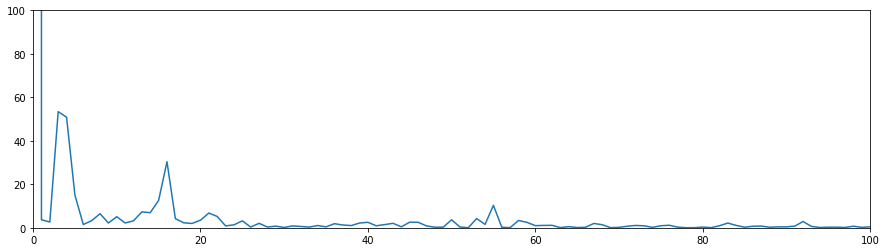

In [ ]:
 plt.figure(figsize=(15,4))
 plt.plot(dataset.complete_examples_features[3,:])
 plt.ylim([0,100])
 plt.xlim([0,100])

## A - Introducción


In [ ]:
from sklearn.model_selection import ParameterGrid

params= {'overlapping_fraction': [1, 1/2, 1/3], 'window_size': [600, 900, 1200]}

grid=[]
for param in ParameterGrid(params):
    grid.append(param)

print(grid)

[{'overlapping_fraction': 1, 'window_size': 600}, {'overlapping_fraction': 1, 'window_size': 900}, {'overlapping_fraction': 1, 'window_size': 1200}, {'overlapping_fraction': 0.5, 'window_size': 600}, {'overlapping_fraction': 0.5, 'window_size': 900}, {'overlapping_fraction': 0.5, 'window_size': 1200}, {'overlapping_fraction': 0.3333333333333333, 'window_size': 600}, {'overlapping_fraction': 0.3333333333333333, 'window_size': 900}, {'overlapping_fraction': 0.3333333333333333, 'window_size': 1200}]


In [ ]:
for param in ParameterGrid(params):
  dataset_param= BCIDataset(csvs_path, subject='AA', channel= 'ch2', **param)  
  print(param)
  print(dataset_param.complete_examples_signal.shape)
  print(dataset_param.complete_examples_features.shape)

Processing subject: AA - session: 1...
Processing subject: AA - session: 0...
Processing subject: AA - session: 2...
{'overlapping_fraction': 1, 'window_size': 600}
(489, 600)
(489, 301)
Processing subject: AA - session: 1...
Processing subject: AA - session: 0...
Processing subject: AA - session: 2...
{'overlapping_fraction': 1, 'window_size': 900}
(326, 900)
(326, 451)
Processing subject: AA - session: 1...
Processing subject: AA - session: 0...
Processing subject: AA - session: 2...
{'overlapping_fraction': 1, 'window_size': 1200}
(244, 1200)
(244, 601)
Processing subject: AA - session: 1...
Processing subject: AA - session: 0...
Processing subject: AA - session: 2...
{'overlapping_fraction': 0.5, 'window_size': 600}
(975, 600)
(975, 301)
Processing subject: AA - session: 1...
Processing subject: AA - session: 0...
Processing subject: AA - session: 2...
{'overlapping_fraction': 0.5, 'window_size': 900}
(649, 900)
(649, 451)
Processing subject: AA - session: 1...
Processing subject: 

Se puede observar que al aumentar el tamaño de la ventana en número de muestras disminuye el número de ejemplos en el dataset final, ya que al ser ventanas de mayor tamaño entran un menor número de veces en el dataset original y por lo tanto se obtiene un menor número de ejemplos; y por otra parte, al disminuir el valor de la fracción de solapamiento se puede observar que aumenta el número de muestras debido a que en una misma ventana se van a solapar un mayor numero de veces ventanas subsiguientes, obteniéndose así el doble de ventanas que las originales si el solapamiento es a la mitad, el triple de ventanas que las originales si el solapamiento es a un tercio, etcétera. En relación a la dimensionalidad, esta, esta dada por el número de muestras que poseen las ventanas de tiempo, por lo que la dimensionalidad se modifica de la misma forma que se modifica el tamaño de la ventana en número de muestras.

## B - Características Temporales

[{'window_size': 600}, {'window_size': 900}, {'window_size': 1200}, {'window_size': 1500}]
Processing subject: JA - session: 2...
Processing subject: JA - session: 1...
{'window_size': 600}
(779, 600)
(779, 301)
Processing subject: JA - session: 2...
Processing subject: JA - session: 1...
{'window_size': 900}
(518, 900)
(518, 451)
Processing subject: JA - session: 2...
Processing subject: JA - session: 1...
{'window_size': 1200}
(386, 1200)
(386, 601)
Processing subject: JA - session: 2...
Processing subject: JA - session: 1...
{'window_size': 1500}
(308, 1500)
(308, 751)


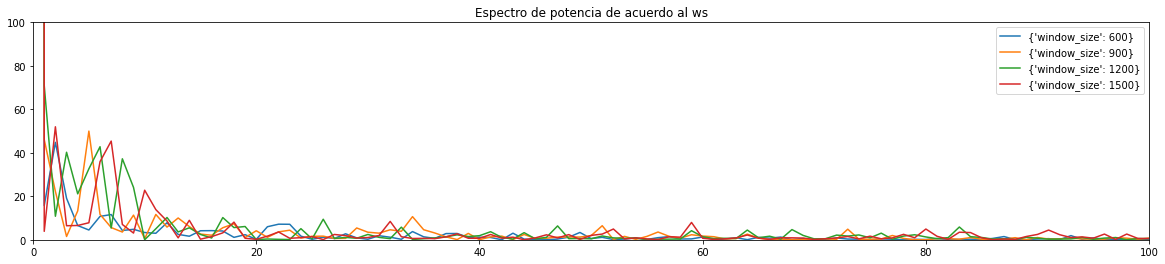

In [ ]:
import seaborn
params_ws= {'window_size': [ 600, 900, 1200, 1500]}

grid_ws=[]
for param_ws in ParameterGrid(params_ws):
    grid_ws.append(param_ws)

print(grid_ws)
plt.figure(figsize=(20, 4))
plt.title('Espectro de potencia de acuerdo al ws')

for param_ws in ParameterGrid(params_ws):
  dataset_param_ws= BCIDataset(csvs_path, subject='JA', channel= 'ch1', **param_ws)  
  print(param_ws)
  print(dataset_param_ws.complete_examples_signal.shape)
  print(dataset_param_ws.complete_examples_features.shape)
  plt.plot(dataset_param_ws.complete_examples_features[3,:], label=param_ws)
  plt.legend()
  
  plt.ylim([0,100])
  plt.xlim([0,100])

Al graficar el espectro de potencia de la señal variando los tamaños de las ventanas en número de muestra se puede observar que al aumentar el tamaño de la ventana la resolución de la frecuencia aumenta ya que se tienen más ejemplos por ventana. Pero la resolución en el tiempo disminuye, ya que al aumentar la ventana se generan menos cantidad de ejemplos temporales.

La frecuencia de resolución nos indica a partir de qué frecuencia el analizador nos va a mostrar datos, es decir que, el analizador no mostrará nada por debajo de la frecuencia de resolución. La frecuencia de resolución se puede calcular dividiendo la frecuencia de muestreo entre el tamaño de la FFT, donde el tamaño de la FFT es el número de datos que el analizador toma en cada medición (FR=FM/FTT).







In [ ]:
fft_tamano= [200, 400,600, 900, 1200, 1500]
fr_list=[]
for p in fft_tamano:
  fr= 200/p
  fr_list.append(fr)
#se obtienen las siguientes resoluciones de frecuencias...
fr_list

[1.0,
 0.5,
 0.3333333333333333,
 0.2222222222222222,
 0.16666666666666666,
 0.13333333333333333]

Como nuestras frecuencias de muestreo requieren una resolucion a partir de 0.5 se considera que el tamano mínimo que debería tener la ventana en muestras, sería de 400 muestras en adelante.

In [ ]:
dataset.complete_dataset.shape

(659112, 10)

In [ ]:
datos2 = dataset.complete_dataset.drop(columns= ['sub_label', 'time', 'subject', 'session', 'sub_sess'])

In [ ]:
datos2.head(5)

,ch0,ch1,ch2,ch3,label
0,2081.61,994.82,2229.93,1975.38,99
1,1926.57,836.23,2065.95,1912.34,99
2,1744.17,650.03,1852.65,1883.84,99
3,1937.29,848.86,2050.07,1970.17,99
4,2079.86,980.78,2222.84,1981.65,99


In [ ]:
def calcular_muestreo_media(columna, ventana):
    try:
        muestreo = []
        for i in range(0, len(columna), ventana):
            muestreo.append(columna[i:i+ventana].mean())
        return muestreo
    except Exception as e:
        print(str(e))

def calcular_muestreo_max(columna, ventana):
    try:
        muestreo = []
        for i in range(0, len(columna), ventana):
            muestreo.append(columna[i:i+ventana].max())
        return muestreo
    except Exception as e:
        print(str(e))

def calcular_muestreo_min(columna, ventana):
    try:
        muestreo = []
        for i in range(0, len(columna), ventana):
            muestreo.append(columna[i:i+ventana].min())
        return muestreo
    except Exception as e:
        print(str(e))

In [ ]:
ventana = 400

In [ ]:
type(datos2)

pandas.core.frame.DataFrame

In [ ]:
df_muestra = pd.DataFrame()
df_muestra['ch0-mean'] = calcular_muestreo_media(datos2['ch0'], ventana)
df_muestra['ch0-max'] = calcular_muestreo_max(datos2['ch0'], ventana)
df_muestra['ch0-min'] = calcular_muestreo_min(datos2['ch0'], ventana)

In [ ]:
df_muestra['ch1-mean'] = calcular_muestreo_media(datos2['ch1'], ventana)
df_muestra['ch1-max'] = calcular_muestreo_max(datos2['ch1'], ventana)
df_muestra['ch1-min'] = calcular_muestreo_min(datos2['ch1'], ventana)

In [ ]:
df_muestra['ch2-mean'] = calcular_muestreo_media(datos2['ch2'], ventana)
df_muestra['ch2-max'] = calcular_muestreo_max(datos2['ch2'], ventana)
df_muestra['ch2-min'] = calcular_muestreo_min(datos2['ch2'], ventana)

In [ ]:
df_muestra['ch3-mean'] = calcular_muestreo_media(datos2['ch3'], ventana)
df_muestra['ch3-max'] = calcular_muestreo_max(datos2['ch3'], ventana)
df_muestra['ch3-min'] = calcular_muestreo_min(datos2['ch3'], ventana)

In [ ]:
df_muestra.to_csv(r'df_muestra.csv', index = False)

In [ ]:
dataset_time= BCIDataset(csvs_path,  feature_extractor= calc_statistics)

In [ ]:
df_time= generate_dataframe(dataset_time.complete_examples_features.round(1), ["max ", "min ", "mean ", "mode "])

In [ ]:
df_time['label'] = dataset_time.complete_labels
df_time.head()

,max ch1,min ch1,mean ch1,mode ch1,max ch2,min ch2,mean ch2,mode ch2,max ch3,min ch3,mean ch3,mode ch3,max ch4,min ch4,mean ch4,mode ch4,label
0,2252.3,1734.4,1971.9,1811.4,1177.1,632.2,884.6,698.8,2421.5,1839.0,2099.2,1880.3,2048.5,1872.8,1961.2,1988.0,99.0
1,2252.3,1759.0,1971.2,1811.4,1177.1,673.0,885.3,698.8,2421.5,1860.4,2099.6,2201.9,2048.5,1880.1,1959.7,2013.6,99.0
2,2252.3,1799.9,1970.3,1811.4,1175.0,707.4,884.7,978.0,2421.5,1899.7,2098.6,2201.9,2048.5,1897.3,1961.3,1965.0,99.0
3,2116.1,1799.9,1956.2,1815.4,1032.0,708.9,869.3,728.6,2244.8,1904.4,2081.5,1921.5,2031.0,1895.0,1956.6,1900.9,99.0
4,2116.1,1811.9,1955.8,2040.8,1032.0,724.2,869.7,763.6,2247.5,1913.9,2081.0,2186.7,2031.0,1895.0,1956.7,1900.9,99.0


In [ ]:
df_time.to_csv(r'df_time.csv', index = False)

Se generó un dataset al cual se le aplicaron las siguientes medidas a las ventanas de la señal cruda: Mínimo, máximo, media, y moda. Todas estas medidas fueron aplicadas a cada uno de los canales y concatenadas en un mismo dataset. Se decidió utilizar los canales concatenados, para así poder tener mas features disponibles para aplicar a un posible modelo. Este dataset fue almacenado en forma de dataframe y en formato csv, denominado df_time, 

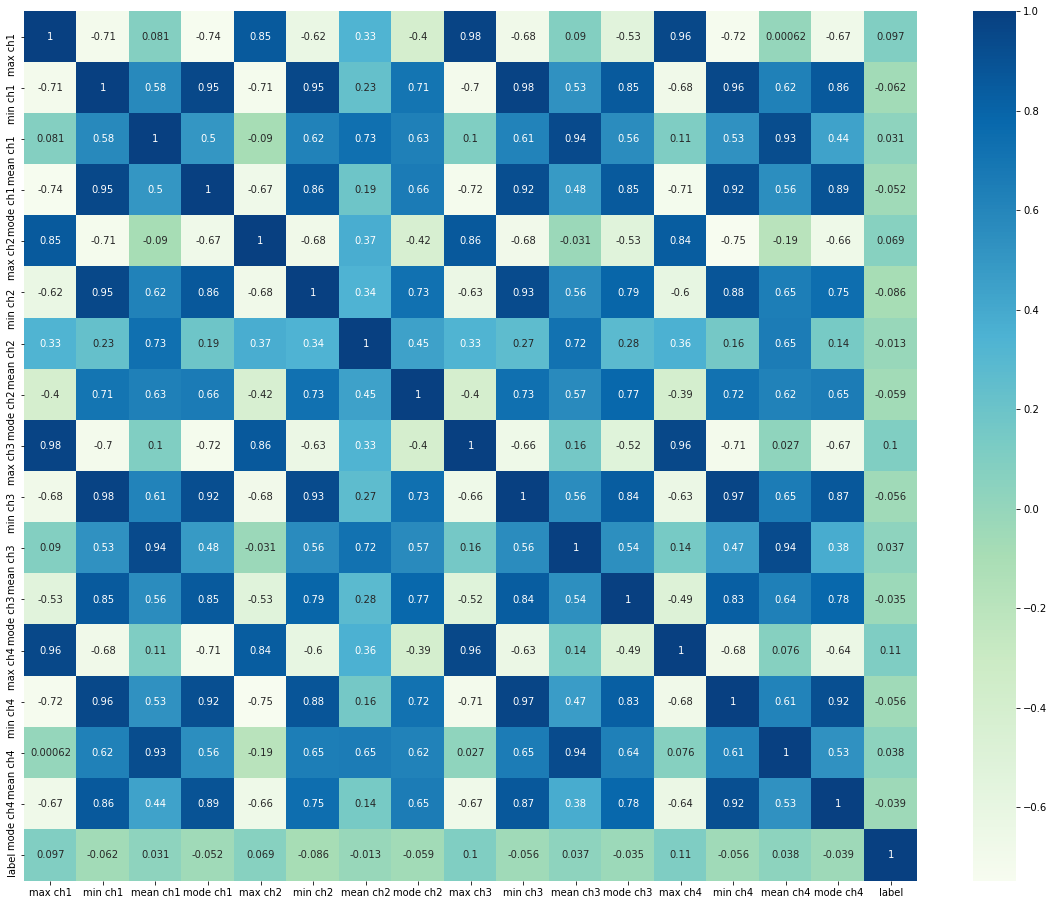

In [ ]:
fig= plt.figure(figsize=(20, 16))
plot = df_time.iloc[:, :17]
correlation_mat = plot.corr()
seaborn.heatmap(correlation_mat, cmap= 'GnBu', annot = True)
plt.show()

A partir de la gráfica de correlación se puede observar que los features generados no tienen buena correlación con los labels, pero existe una cierta correlación entre ellos.

<IPython.core.display.Javascript object>

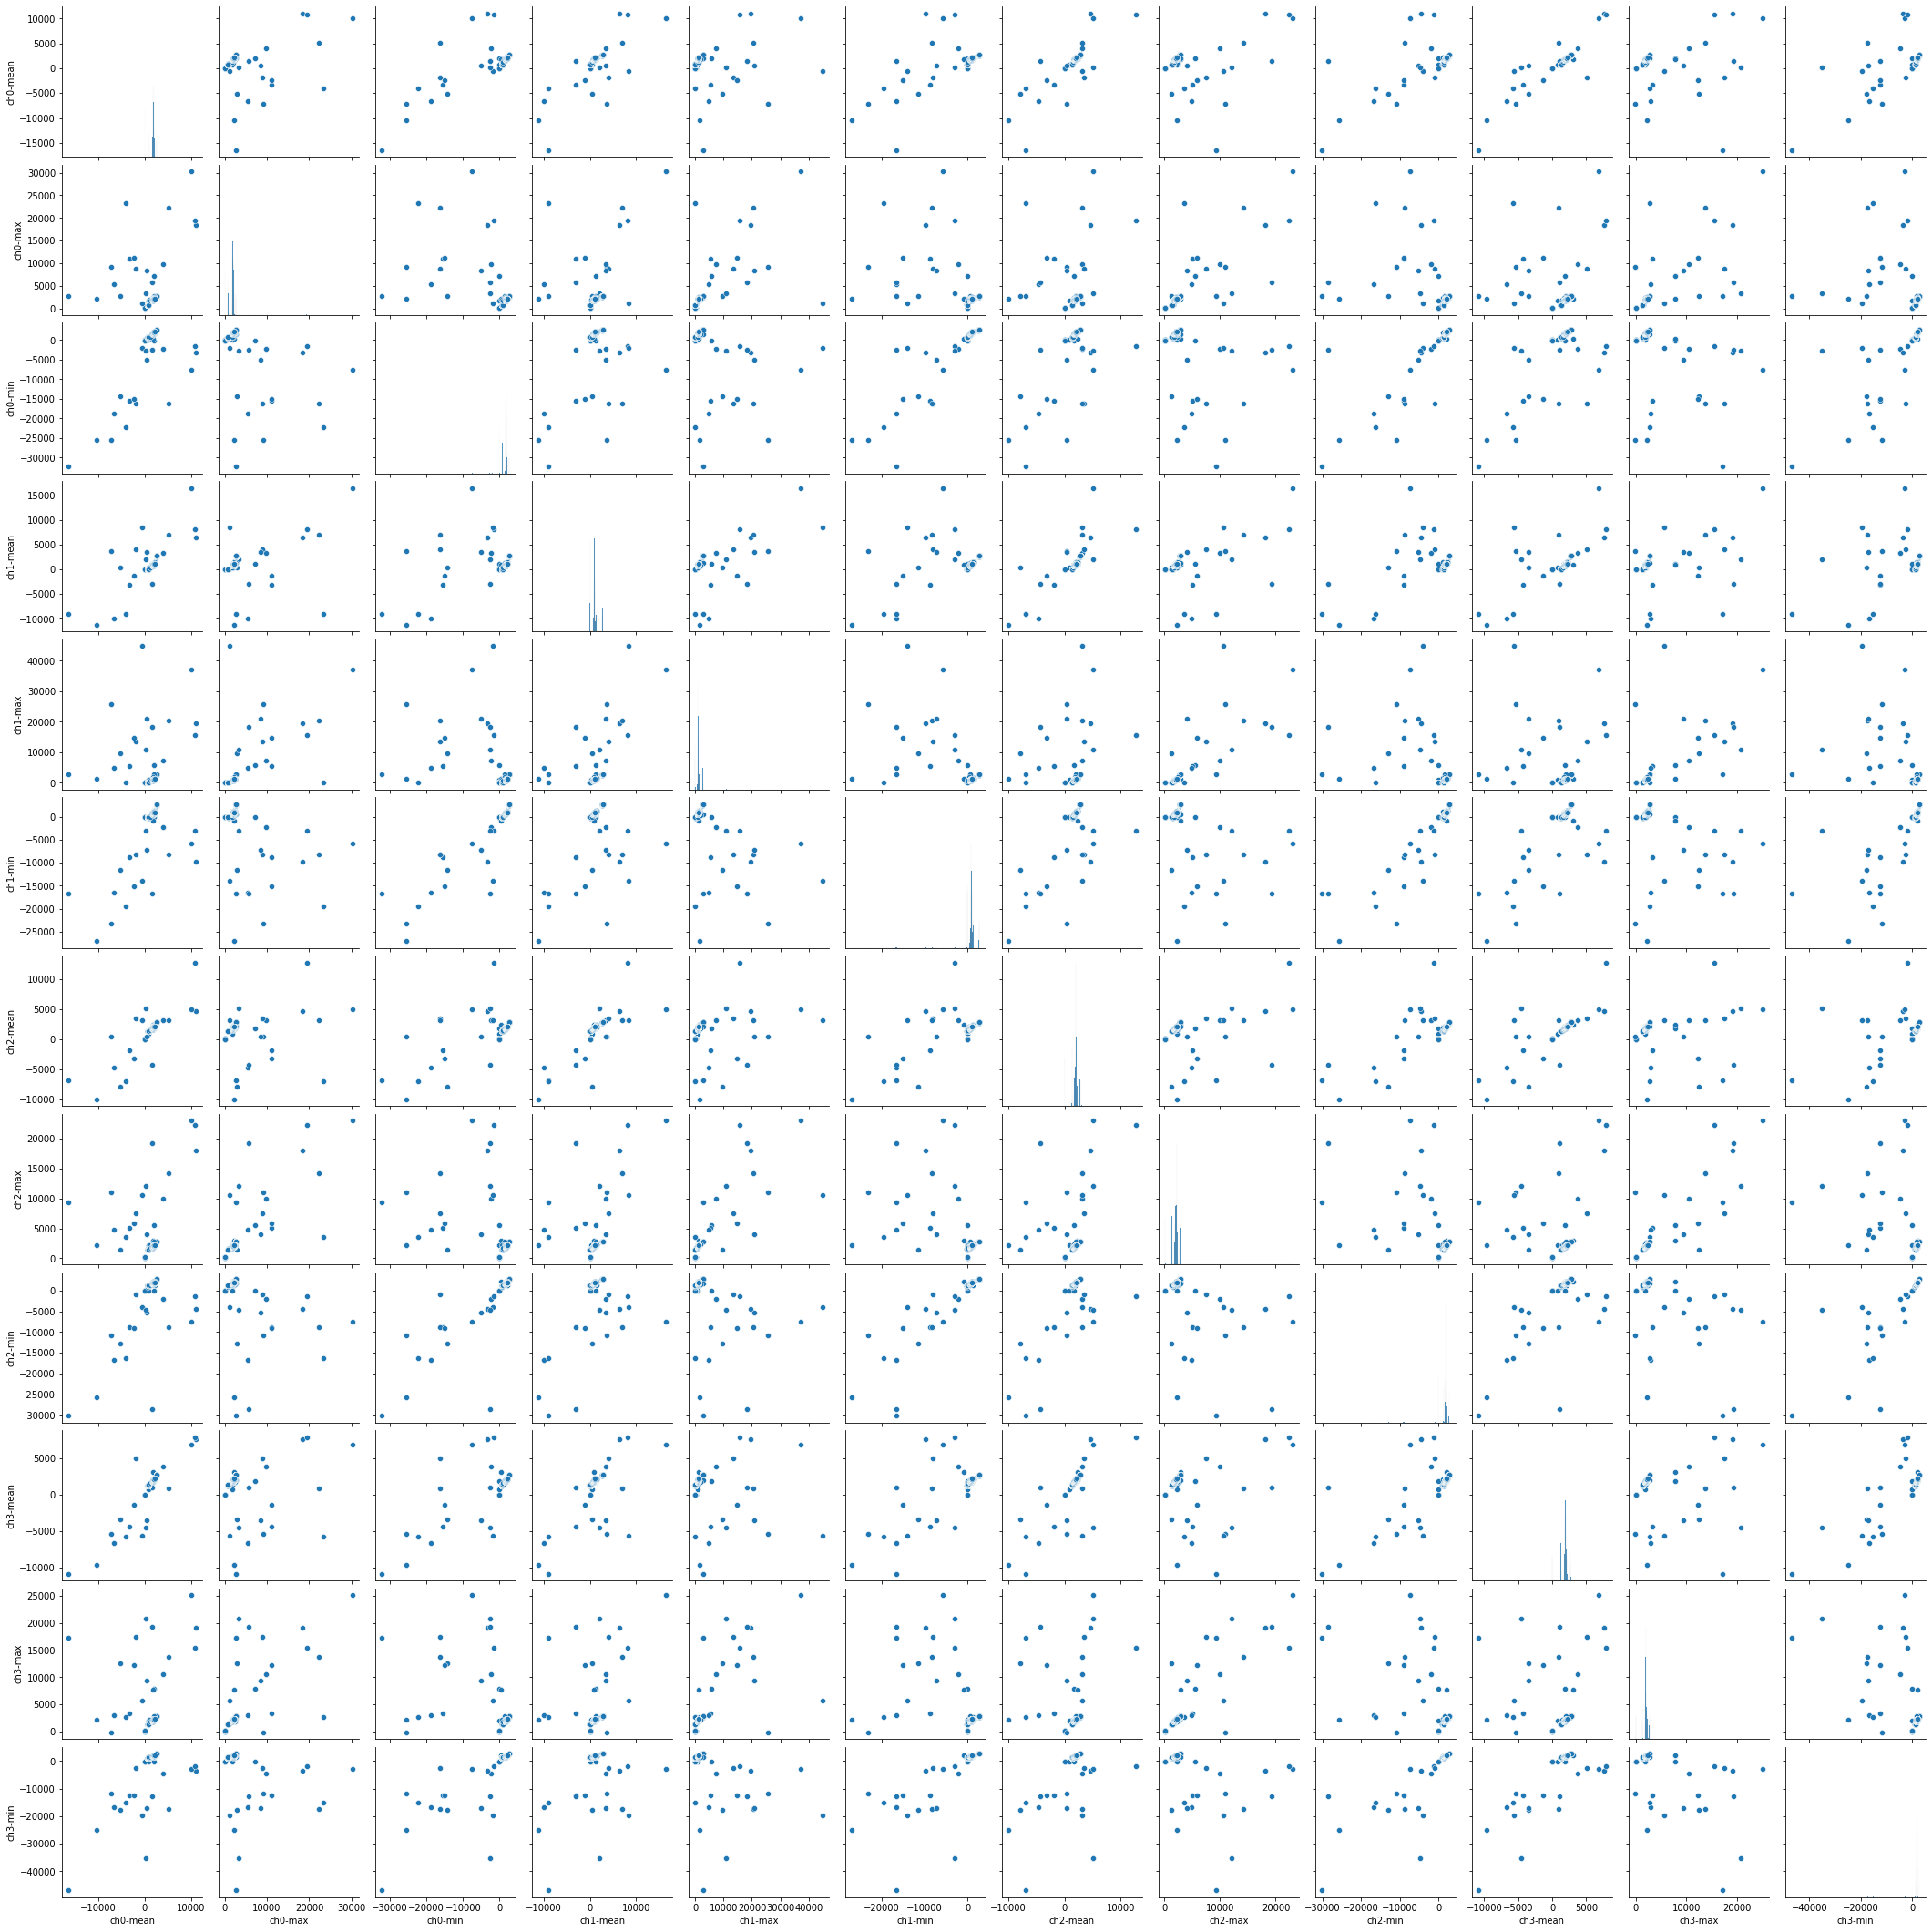

In [ ]:
sns.pairplot(df_muestra, palette='Spectral')

## C - Caracteristicas Espectrales (en frecuencia)

Se generó el dataset a partir de la clase BCIDataset utilizando el feature de extracción la función ¨filtered_fft_features¨, la cual le aplica la transformada de Fourier a las ventanas de tiempo, y a su vez filtra la señal. Se decidió trabajar con los canales concatenados en todos los casos siguientes, para de esta forma disponer de más features para la posible aplicación de un modelo de machine learning. 

In [ ]:
dataset_frec= BCIDataset(csvs_path,  feature_extractor= filtered_fft_features)

Processing subject: AA - session: 1...
Processing subject: AA - session: 0...
Processing subject: AA - session: 2...
Processing subject: JA - session: 2...
Processing subject: JA - session: 1...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


En el dominio de la frecuencia se utilizó como extractor de features la frecuencia máxima obtenida en cada canal y por cada ventana de tiempo, luego de aplicar el espectro de potencia a la ventana, y posteriormente se utilizó la media del resultado de la transformada de Fourier sobre la ventana de tiempo. Ambos dataset generados fueron almacenados en Dataframes, y guardados en formatos csv, como df_frec_max y df_sxx_mean, respectivamente.

In [ ]:
dataset_frec_max= BCIDataset(csvs_path, feature_extractor= filtered_fft_features_max) 

Processing subject: AA - session: 1...
Processing subject: AA - session: 0...
Processing subject: AA - session: 2...
Processing subject: JA - session: 2...
Processing subject: JA - session: 1...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


In [ ]:
df_frec_max= generate_dataframe(dataset_frec_max.complete_examples_features.round(1),['Frec max '])

In [ ]:
df_frec_max['label'] = dataset_frec_max.complete_labels
df_frec_max.head()

,Frec max ch1,Frec max ch2,Frec max ch3,Frec max ch4,label
0,11.3,11.3,11.3,11.8,99.0
1,13.3,16.2,13.3,16.0,99.0
2,18.4,16.2,18.4,13.1,99.0
3,12.2,16.9,16.9,14.9,99.0
4,13.6,16.4,18.4,18.4,99.0


In [ ]:
df_frec_max.to_csv(r'df_frec_max.csv', index = False)

In [ ]:
dataset_sxx_mean= BCIDataset(csvs_path, feature_extractor= filtered_fft_features_mean) 

Processing subject: AA - session: 1...
Processing subject: AA - session: 0...
Processing subject: AA - session: 2...
Processing subject: JA - session: 2...
Processing subject: JA - session: 1...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


In [ ]:
df_sxx_mean= generate_dataframe(dataset_sxx_mean.complete_examples_features.round(2),['Tff mean '])

In [ ]:
df_sxx_mean['label'] = dataset_sxx_mean.complete_labels
df_sxx_mean.head()

,Tff mean ch1,Tff mean ch2,Tff mean ch3,Tff mean ch4,label
0,0.88,1.01,1.03,0.18,99.0
1,0.72,0.81,0.87,0.12,99.0
2,0.23,0.26,0.26,0.07,99.0
3,0.17,0.15,0.19,0.09,99.0
4,0.17,0.20,0.21,0.10,99.0


In [ ]:
df_sxx_mean.to_csv(r'df_sxx_mean.csv', index = False)

<IPython.core.display.Javascript object>

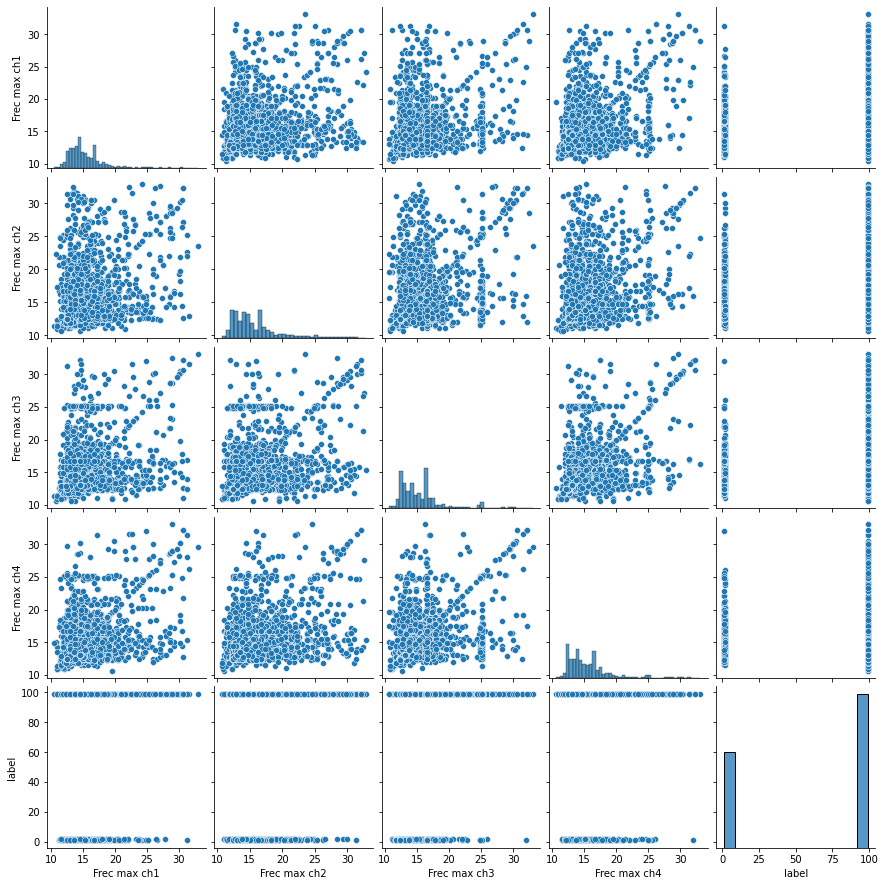

In [ ]:
sns.pairplot(df_frec_max, palette='Spectral')

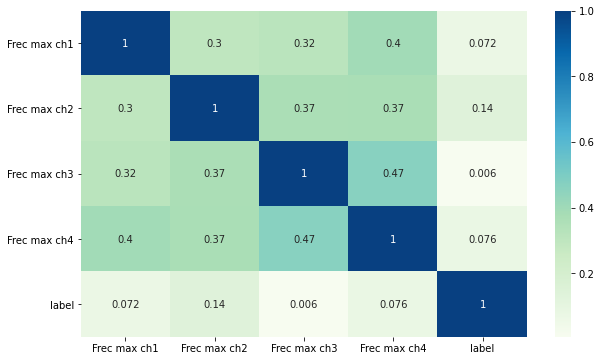

In [122]:
fig= plt.figure(figsize=(10, 6))
plot_fm = df_frec_max.iloc[:, :]
correlation_mat_fm = plot_fm.corr()
seaborn.heatmap(correlation_mat_fm, cmap= 'GnBu', annot = True)
plt.show()

Para este caso, en el que se tomó como feature de extracción la frecuencia máxima del espectro de potencia aplicado sobre la ventana de tiempo, se observa que no se obtienen los resultados que se desearían, ya que no existe correlación entre los features y las etiquetas como se esperaría observar, quizas se deba a que existen pocos ejemplos, y la mayoría de ellos pertenecen a una etiqueta en la cual el paciente no observa ningún estímulo (label 99), por lo que corresponderían a ruido en el análisis de interés.

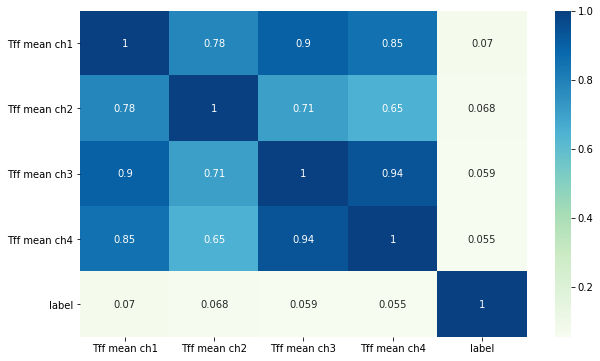

In [ ]:
fig= plt.figure(figsize=(10, 6))
plot_mean = df_sxx_mean.iloc[:, 0:12]
correlation_mat_mean = plot_mean.corr()
seaborn.heatmap(correlation_mat_mean, cmap= 'GnBu', annot = True)
plt.show()

Para este otro caso, en el que se tomó como feature de extracción la media del resultado de aplicar la transformada de Fourier sobre la ventana de tiempo, se observa que tampoco se obtienen los resultados que se desearían, ya que no existe correlación entre los features y las etiquetas como se esperaría observar, al igual que sucede en el caso anterior, quizas se deba a que como en el otro caso existen pocos ejemplos, y la mayoría de ellos pertenecen a una etiqueta en la cual el paciente no observa ningún estímulo (label 99), por lo que corresponderían a ruido en el análisis de interés, o quizas pueda ser porque no es un feature de extracción adecuado para aplicarle a la señal.

##D - Particionando el dataset


In [ ]:
df_time.head()

,max ch1,min ch1,mean ch1,mode ch1,max ch2,min ch2,mean ch2,mode ch2,max ch3,min ch3,mean ch3,mode ch3,max ch4,min ch4,mean ch4,mode ch4,label
0,2252.3,1734.4,1971.9,1811.4,1177.1,632.2,884.6,698.8,2421.5,1839.0,2099.2,1880.3,2048.5,1872.8,1961.2,1988.0,99.0
1,2252.3,1759.0,1971.2,1811.4,1177.1,673.0,885.3,698.8,2421.5,1860.4,2099.6,2201.9,2048.5,1880.1,1959.7,2013.6,99.0
2,2252.3,1799.9,1970.3,1811.4,1175.0,707.4,884.7,978.0,2421.5,1899.7,2098.6,2201.9,2048.5,1897.3,1961.3,1965.0,99.0
3,2116.1,1799.9,1956.2,1815.4,1032.0,708.9,869.3,728.6,2244.8,1904.4,2081.5,1921.5,2031.0,1895.0,1956.6,1900.9,99.0
4,2116.1,1811.9,1955.8,2040.8,1032.0,724.2,869.7,763.6,2247.5,1913.9,2081.0,2186.7,2031.0,1895.0,1956.7,1900.9,99.0


In [ ]:
df_frec_join= df_frec_max.copy()
df_frec_join['Tff mean ch1']= df_sxx_mean['Tff mean ch1']
df_frec_join['Tff mean ch2']= df_sxx_mean['Tff mean ch2']
df_frec_join['Tff mean ch3']= df_sxx_mean['Tff mean ch3']
df_frec_join['Tff mean ch4']= df_sxx_mean['Tff mean ch4']
df_frec_join.head()

,Frec max ch1,Frec max ch2,Frec max ch3,Frec max ch4,label,Tff mean ch1,Tff mean ch2,Tff mean ch3,Tff mean ch4
0,11.3,11.3,11.3,11.8,99.0,0.88,1.01,1.03,0.18
1,13.3,16.2,13.3,16.0,99.0,0.72,0.81,0.87,0.12
2,18.4,16.2,18.4,13.1,99.0,0.23,0.26,0.26,0.07
3,12.2,16.9,16.9,14.9,99.0,0.17,0.15,0.19,0.09
4,13.6,16.4,18.4,18.4,99.0,0.17,0.20,0.21,0.10


In [ ]:
df_time['label'].value_counts()

99.0    1337
2.0      434
1.0      402
Name: label, dtype: int64

In [ ]:
df_frec_join['label'].value_counts()

99.0    1337
2.0      434
1.0      402
Name: label, dtype: int64

In [ ]:
metadata_dataset = pd.DataFrame(dataset_time.complete_metadata, columns = ['pureness', 't_start', 't_end', 'subject', 'session'])

In [ ]:
metadata_dataset.pureness.value_counts()

True     1499
False     674
Name: pureness, dtype: int64

Como se puede observar las clases están muy desbalanceadas, y hay un gran número de ejemplos impuros, pero se considera que es conveniente conservar esas características ya que es lo que ocurriría en la realidad, es decir, este sería el tipo de información al cual el modelo se enfrentaría al ser aplicado en la vida real. 

En el particionado del dataset se considera por un lado como variable dependiente (y) las etiquetas, y como variable independiente (x) las features; debido a que se decidió analizar todos las sesiones y todos los pacientes juntos, se dividirá una parte del dataset (20%) para conservar como muestras de evaluacion (test), y el resto del datase (80%) será utilizado como muestras de entrenamiento (train), siendo estos escogidos al azar, de esta forma se evita que se introduzca un sesgo.

In [128]:
y= dataset_frec_max.complete_labels
X= dataset_frec_max.complete_examples_features

In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

En adición se puede utilizar kfold para realizar validación cruzada.